In [1]:
import scipy as sp
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from time import time
import matplotlib as mpl
mpl.rc('figure', figsize=[10,5])

import hiive.mdptoolbox, hiive.mdptoolbox.example, hiive.mdptoolbox.mdp
import gym
from frozenlake_env import FrozenLakeEnv


# Frozen Lake 4x4


In [2]:
# credit https://github.com/luclement/ml-assignment4/blob/master/frozen_lake.ipynb
def simulateEnv(env, policy, numEpisodes, max_iters=1000):
    rewards = []
    lengths = []
    
    for i in range(numEpisodes):
        env.reset()
        state = 0
        done = False
        count = 0
        reward_sum = 0

        while not done:
            action = policy[state]
            state, reward, done, _ = env.step(action)
            reward_sum += reward
            count += 1
            
            if count > max_iters:
                failed += 1
                break
        
        lengths.append(count)
        rewards.append(reward_sum)
    
    avg_reward = sum(rewards) / numEpisodes
    return lengths, rewards, avg_reward

In [3]:
# credit https://github.com/wesley-smith/CS7641-assignment-4/blob/f3d86e37504dda563f65b3267610a30f09d01c77/helpers.py
TERM_STATE_MAP = {"4x4": [5, 7, 11, 12], "8x8": [19, 29, 35, 41, 42, 46, 49, 52, 54, 59]}
GOAL_STATE_MAP = {"4x4": [15], "8x8": [63]}

def visualize_env(env, env_name, title=None):
    shape = env.desc.shape
    M = shape[0]
    N = shape[1]
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[env_name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[env_name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(arr, cmap='cool')
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (i, j) == (0, 0):
                ax.text(j, i, 'S', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in TERM_STATE_MAP[env_name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[env_name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, 'F', ha='center', va='center', color='k', size=18)

    fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()


def visualize_policy(pi, env_name, shape, title=None):
    M = shape[0]
    N = shape[1]
    actions = np.asarray(pi).reshape(shape)
    mapping = {
        0: '←',
        1: '↓',
        2: '→',
        3: '↑'
    }
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[env_name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[env_name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(arr, cmap='cool')
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[env_name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[env_name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, mapping[actions[i, j]], ha='center', va='center', color='k', size=18)
    # fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()

def render_policy(pi, env_name, shape):
    actions = np.argmax(pi, axis=1)
    for index in TERM_STATE_MAP[env_name]:
        actions[index] = 999
    for index in GOAL_STATE_MAP[env_name]:
        actions[index] = 1000

    pi = np.reshape(actions, shape)

    mapping = {
        0: ' < ',
        1: ' v ',
        2: ' > ',
        3: ' ^ ',
        999: ' . ',
        1000: ' $ '
    }
    mapper = np.vectorize(lambda k: mapping[k])
    np.apply_along_axis(lambda row: print(' '.join(row)), axis=1, arr=mapper(pi))


def visualize_value(V, env_name, shape, title=None):
    V = np.asarray(V)
    M = shape[0]
    N = shape[1]
    fig, ax = plt.subplots(figsize=(6,6))
    arr = V.reshape(shape)
    im = ax.imshow(arr, cmap='cool')
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[env_name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k')
            elif (N * i + j) in GOAL_STATE_MAP[env_name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k')
            else:
                ax.text(j, i, '%.2f' % (arr[i, j]), ha='center', va='center', color='k')
    # fig.tight_layout()
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('State-value estimate', rotation=-90, va="bottom")
    if title:
        ax.set_title(title)
    plt.show()

def better_desc(desc):
    mapping = {
        b'S': b' S ',
        b'F': b' * ',
        b'H': b' O ',
        b'G': b' $ '
    }
    mapper = np.vectorize(lambda k: mapping[k])
    return mapper(desc)

In [4]:
env = FrozenLakeEnv(map_name="8x8", penalty=0)

# credit https://github.com/luclement/ml-assignment4/blob/master/frozen_lake.ipynb
nA, nS = env.nA, env.nS
T = np.zeros([nA, nS, nS])
R = np.zeros([nS, nA])
for state in range(nS):
    for action in range(nA):
        trans = env.P[state][action]
        for p_transitions, next_state, reward, _ in trans:
            T[action, state, next_state] += p_transitions
            R[state, action] = reward
        T[action, state, :] /= np.sum(T[action, state, :])
print(T)

[[[0.665 0.    0.    ... 0.    0.    0.   ]
  [0.33  0.335 0.    ... 0.    0.    0.   ]
  [0.    0.33  0.335 ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.335 0.    0.   ]
  [0.    0.    0.    ... 0.33  0.335 0.   ]
  [0.    0.    0.    ... 0.    0.    1.   ]]

 [[0.335 0.335 0.    ... 0.    0.    0.   ]
  [0.335 0.    0.335 ... 0.    0.    0.   ]
  [0.    0.335 0.    ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.33  0.335 0.   ]
  [0.    0.    0.    ... 0.335 0.33  0.335]
  [0.    0.    0.    ... 0.    0.    1.   ]]

 [[0.335 0.33  0.    ... 0.    0.    0.   ]
  [0.    0.335 0.33  ... 0.    0.    0.   ]
  [0.    0.    0.335 ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.335 0.33  0.   ]
  [0.    0.    0.    ... 0.    0.335 0.33 ]
  [0.    0.    0.    ... 0.    0.    1.   ]]

 [[0.665 0.335 0.    ... 0.    0.    0.   ]
  [0.335 0.33  0.335 ... 0.    0.    0.   ]
  [0.    0.335 0.33  ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.    0.335 0.   ]
  

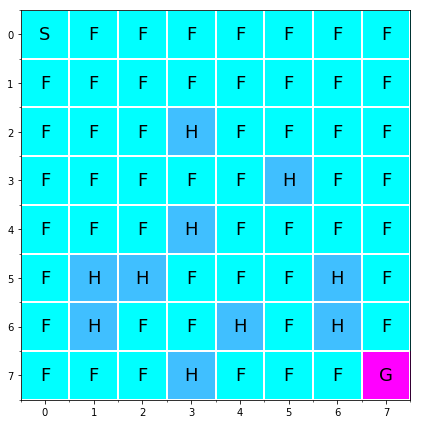

In [5]:
visualize_env(env, "8x8")

In [9]:
# want to explore different gamma values
arr_gammas = np.arange(0.80, 1.0, 0.01)
print(arr_gammas)

[0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99]


## Value Iteration

optimal policy:  (0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 3, 2, 2, 2, 1, 1, 2, 0, 0, 2, 3, 2, 1, 1, 2, 3, 1, 0, 0, 2, 1, 3, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0)
gamma:  0.8 avg reward:  0.242 policy threshold:  0.002499999999999999
iterations for convergence:  13
############################################################
optimal policy:  (1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 1, 1, 2, 0, 0, 2, 3, 2, 1, 1, 2, 3, 1, 0, 0, 2, 1, 3, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0)
gamma:  0.81 avg reward:  0.312 policy threshold:  0.002345679012345678
iterations for convergence:  14
############################################################
optimal policy:  (1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 1, 1, 2, 0, 0, 2, 3, 2, 1, 3, 2, 3, 1, 0, 0, 2, 1, 3, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0)
gamma:  0.8200000000000001 avg reward:  0

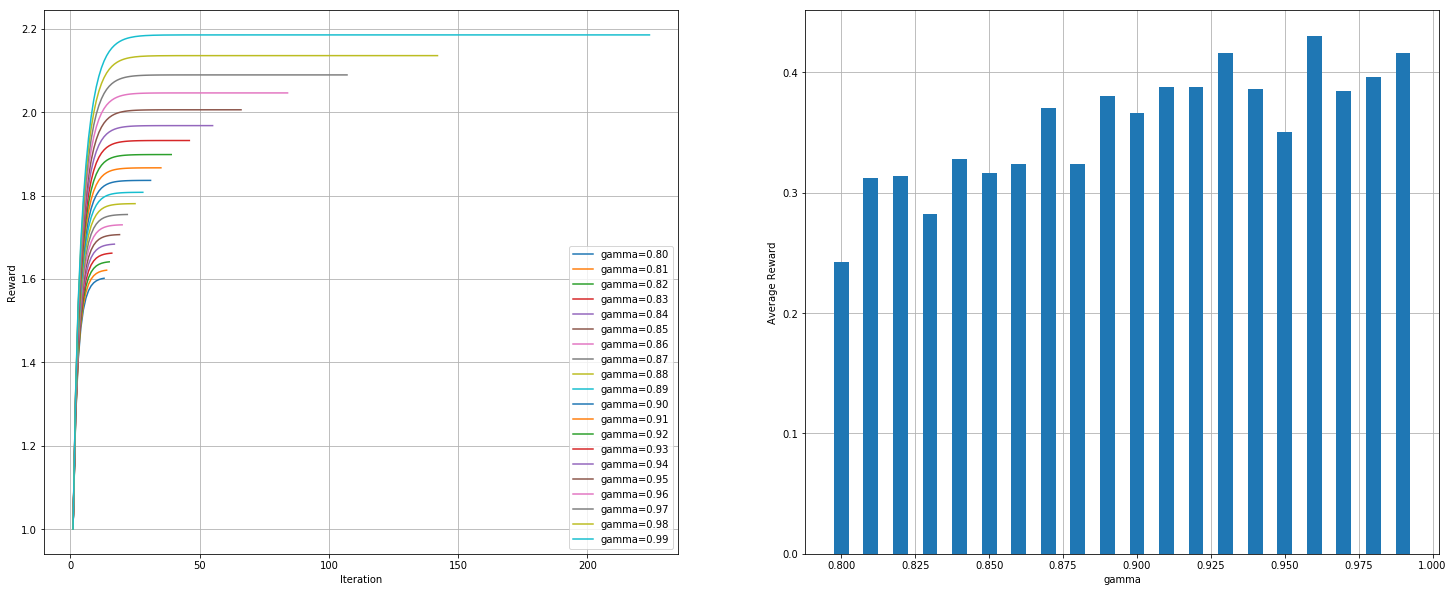

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
avg_rew = []
for gamma in arr_gammas:
    VI = hiive.mdptoolbox.mdp.ValueIteration(T, R, gamma)
    VI.verbose = False
    VI.run()
    numEpisodes = 500
    print('optimal policy: ', VI.policy)
    lengths, rewards, avg_reward = simulateEnv(env, VI.policy, numEpisodes)
    print('gamma: ', gamma, 'avg reward: ', avg_reward, 'policy threshold: ', VI.thresh)
    print('iterations for convergence: ', VI.iter)
    print('############################################################')
    avg_rew.append(avg_reward)
    
    ax1.plot(range(1, VI.iter + 1), [run_stats['Reward'] for run_stats in VI.run_stats], label="gamma=%.2f" % gamma)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Reward')
    ax1.legend()
    ax1.grid(b=True)
    
ax2.bar(arr_gammas, avg_rew, width=0.005)
ax2.set_xlabel('gamma')
ax2.set_ylabel('Average Reward')
ax2.set_axisbelow(True)
ax2.grid()

plt.show()

224 0.017689228057861328
(3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0)


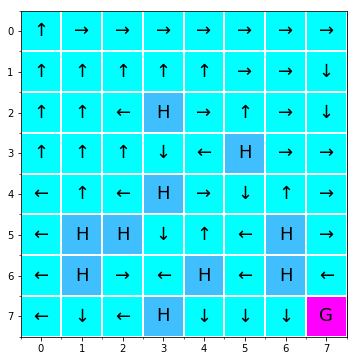

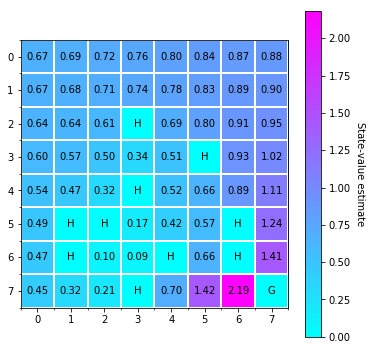

In [13]:
vi = hiive.mdptoolbox.mdp.ValueIteration(T, R, 0.99, epsilon=0.01)
vi.run()
print(vi.iter, vi.time)
print(vi.policy)
visualize_policy(vi.policy, "8x8", (8,8))
visualize_value(vi.V, "8x8", (8,8))

In [ ]:
P,R = hiive.mdptoolbox.example.forest()
value = hiive.mdptoolbox.mdp.ValueIteration(P, R, 0.96)